In [73]:
import numpy as np                # импорт бибилиотеки numpy
import matplotlib.pyplot as plt   # импорт модуля matplotlib.pyplot

# Сами диф. уравнения
$\begin{array}{ccl}
y1' = a(-(y1^3/3 - y1)+y2) \\
y2' = -y1+A*coswt,  \\
\end{array}$

# Метод ФДН

### Константы

In [74]:
a = 1e4
A = 1.1
omega = 10000.0

In [75]:
def calculateFunction(t, u, num):
    if u[0] > 1000:
        print("\n", t, u)
    if num == 2:
        return [a * (-(u[0]**3/3 - u[0]) + u[1]), -u[0] + A * np.cos(omega * t)]
    else:
        return [a * (-(u[0]**3/3 - u[0]) + u[1]), -u[0] + A * np.cos(omega * t), 1.0]


def nextU1(t, uArr, tau, func):
    uLast = uArr[-1]
    eps = 1e-3
    uNext = uLast + tau * np.array(func(t, uLast, 2))
    
    while np.linalg.norm(uNext - uLast) > eps:
        uLast = uNext
        uNext = uLast + tau * np.array(func(t, uLast, 2))
    
    return uNext

def nextU2(t, uArr, tau, func):
    uLast = uArr[-1]
    eps = 1e-3
    uNext = 2.0/3.0 * (tau * np.array(func(t, uLast, 2)) + 2.0 * np.array(uArr[-1]) - 0.5 * np.array(uArr[-2]))
    
    while np.linalg.norm(uNext - uLast) > eps:
        uLast = uNext
        uNext = 2.0/3.0 * (tau * np.array(func(t, uLast, 2)) + 2.0 * np.array(uArr[-1]) - 0.5 * np.array(uArr[-2]))
    
    return uNext

def nextU3(t, uArr, tau, func):
    uLast = uArr[-1]
    eps = 1e-3
    uNext = 6.0/11.0 * (tau * np.array(func(t, uLast, 2)) + 3.0 * np.array(uArr[-1]) - 1.5 * np.array(uArr[-2]) + 1.0/3.0 * np.array(uArr[-3]))
    
    while np.linalg.norm(uNext - uLast) > eps:
        uLast = uNext
        uNext = 6.0/11.0 * (tau * np.array(func(t, uLast, 2)) + 3.0 * np.array(uArr[-1]) - 1.5 * np.array(uArr[-2]) + 1.0/3.0 * np.array(uArr[-3]))
    
    return uNext


## Построение графика

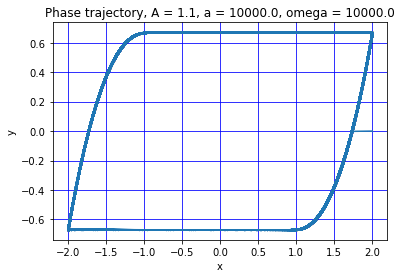

In [76]:
np.set_printoptions(floatmode='maxprec', suppress=True)
tau = 1e-5
u0 = [2.0, 0.0]
uArr = [u0]
res = u0
lastU = res
res = nextU1(0.0, uArr, tau, calculateFunction)
uArr.append(res)
lastU = res
res = nextU2(tau, uArr, tau, calculateFunction)
uArr.append(res)

for t in np.arange(tau * 2, 200.0, tau):
    lastU = res
    res = nextU3(t, uArr, tau, calculateFunction)
    uArr.append(res)

xArr, yArr = zip(*uArr)
plt.figure()
plt.plot(xArr[::100], yArr[::100], '.-', ms=1)
plt.grid(True, color='blue', linestyle='-')
plt.title(f"Phase trajectory, A = {A}, a = {a}, omega = {omega}")
plt.ylabel("y")
plt.xlabel("x")
plt.show()

# Метод Рунге Кутта (явные)  

### Константы

In [77]:
a = 1e3
A = 0.4
omega = 10.0

In [78]:
def calculateK(t, u, s, tau, betaMatrix, alphaArray):
    if s <= 1:
        return calculateFunction(u)
    
    kArray = np.empty((s + 1, 2))
    kArray[0] = calculateFunction(t, u, 2)
    
    for i in range(1, s):
        uNew = np.copy(u)
        
        for j in range(i):
            uNew += tau * betaMatrix[i - 1][j] * kArray[j]
        
        kArray[i] = calculateFunction(t + tau * alphaArray[i], uNew,2)
    
    return kArray


def calculateNextU(u, tau, gammaArray, kArray):
    result = [0, 0]
    
    for i in range(len(gammaArray)):
        result += kArray[i] * gammaArray[i] * tau
    
    return np.copy(u) + result



## Построение графика

Text(0.5, 0, 'x')

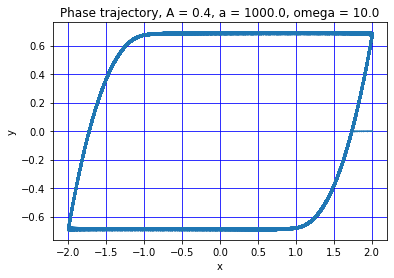

In [79]:

np.set_printoptions(floatmode='maxprec', suppress=True)
tau = 1e-4
initialU = [2.0, 0.0]

betaMatrix = np.zeros((2, 2))
betaMatrix[0][0] = 0.25
betaMatrix[0][1] = 0.25 - np.sqrt(3)/6
betaMatrix[1][0] = 0.25 + np.sqrt(3)/6
betaMatrix[1][1] = 0.25

alphaArray = np.array([0.5 - np.sqrt(3)/6, 0.5 + np.sqrt(3)/6])
gammaArray = np.array([0.5, 0.5])

uArray = [initialU]
result = initialU

for t in np.arange(0.0, 200.0, tau):
    lastU = result
    kArray = calculateK(t, lastU, 2, tau, betaMatrix, alphaArray)
    result = calculateNextU(lastU, tau, gammaArray, kArray)
    uArray.append(result)

xArray, yArray = zip(*uArray)
plt.plot(xArray, yArray, '.-', ms = 1)
plt.grid(True, color='blue', linestyle='-')
plt.title(f"Phase trajectory, A = {A}, a = {a}, omega = {omega}")
plt.ylabel("y")
plt.xlabel("x")

# Метод Розенброка

### Константы

In [80]:
a = 1e4
A = 1.2
omega = 1000.0

In [81]:
def calculateNextState(u, timeStep, gammaArray, kArray):
    result = [0, 0, 0]
    for i in range(len(gammaArray)):
        result += kArray[i] * gammaArray[i] * timeStep
    return np.copy(u) + result

def calculateJacobian(u):
    ret = np.zeros((len(u), len(u)))
    ret[0][0] = -a * (u[0] * u[0] + 1)
    ret[0][1] = a
    ret[1][0] = -1
    ret[1][2] = -A * omega * np.sin(omega * u[2])
    ret[2][2] = 1
    return ret

def calculateLeftMatrix(timeStep, initialState):
    dF = calculateJacobian(initialState)
    ret = np.identity(len(initialState)) - (1 + 1j) / 2 * timeStep * dF
    return ret

def calculateRightSide(func, u, timeStep):
    uNew = np.copy(u)
    uNew[2] += timeStep / 2
    return func(uNew[2], uNew, 3)


## Построение графика

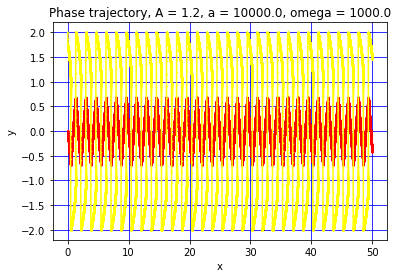

In [82]:
np.set_printoptions(floatmode='maxprec', suppress=True)

timeStep = 1e-4
initialState = [2.0, 0.0, 0.0]
stateArray = [initialState]
resultState = initialState
leftMatrix = calculateLeftMatrix(timeStep, initialState)

for t in np.arange(0.0, 50.0, timeStep):
    lastState = resultState
    rightSideState = calculateRightSide(calculateFunction, lastState, timeStep)
    w = np.linalg.solve(leftMatrix, rightSideState)
    resultState = lastState + timeStep * np.real(w)
    stateArray.append(resultState)

xArray, yArray, tArray = zip(*stateArray)

plt.plot(tArray, yArray, '.-', ms=1, color='red')
plt.plot(tArray, xArray, '.-', ms=1, color='yellow')
plt.grid(True, color='blue', linestyle='-')
plt.title(f"Phase trajectory, A = {A}, a = {a}, omega = {omega}")
plt.ylabel("y")
plt.xlabel("x")
plt.show()